In [1]:
import os
import pickle
import random
from collections import defaultdict
from pathlib import Path
from time import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import (accuracy_score, average_precision_score,
                             cohen_kappa_score, explained_variance_score,
                             f1_score, log_loss, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             median_absolute_error, precision_score, r2_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from tqdm import tqdm

plt.style.use("ggplot")
tqdm.pandas()

In [2]:
class CFG:
    name = "exp002"
    seed = 42
    n_fold = 5

    path_input = Path("../input")
    path_output = Path("../output")

    top_n = 20

    lgb_model_params = {
        "objective": "binary",
        "verbosity": -1,
        "learning_rate": 0.1,
        "random_state": seed,
        "bagging_fraction": 0.9,
    }

    lgb_train_params = {
        "num_boost_round": 999999,
    }

In [3]:
class Timer:
    def __init__(
        self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "
    ):
        if prefix:
            format_str = str(prefix) + sep + format_str
        if suffix:
            format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True


def setup(CFG):
    # expフォルダを作成
    CFG.path_exp = CFG.path_output / CFG.name
    CFG.path_exp.mkdir(parents=True, exist_ok=True)

    # seedの設定
    set_seed(CFG.seed)

    return CFG

In [5]:
CFG = setup(CFG)

In [6]:
# データの読み込み
train_log_df = pd.read_csv(CFG.path_input / "train_log.csv")
train_label_df = pd.read_csv(CFG.path_input / "train_label.csv")

test_log_df = pd.read_csv(CFG.path_input / "test_log.csv")
test_session_df = pd.read_csv(CFG.path_input / "test_session.csv")

yado_df = pd.read_csv(CFG.path_input / "yado.csv")
yado_embedding_df = pd.read_parquet(CFG.path_input / "image_embeddings.parquet")

In [7]:
# すべてのログデータはあとあと参照をするので先に作っておきます.
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

In [8]:
yado_df

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
0,1,0,129.0,1.0,0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c
1,2,0,23.0,1.0,0,NaN,NaN,NaN,NaN,d86102dd9c232bade9a97dccad40df48,b4d2fb4e51ea7bca80eb1270aa474a54,5c9a8f48e9df0234da012747a02d4b29,4ee16ee838dd2703cc9a1d5a535f0ced
2,3,0,167.0,1.0,1,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c
3,4,0,144.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52c9ea83f2cfe92be54cb6bc961edf21,1cc3e1838bb0fd0fde0396130b1f82b9
4,5,0,41.0,1.0,1,NaN,NaN,NaN,NaN,43875109d1dab93592812c50d18270a7,75617bb07a2785a948ab1958909211f1,9ea5a911019b66ccd42f556c42a2fe2f,be1b876af18afc4deeb3081591d2a910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13801,13802,0,10.0,1.0,1,NaN,NaN,NaN,NaN,c312e07b7a5d456d53a5b00910a336e1,558ac1909f0318b82c621ab250329d6d,80fb3c5ad0c89931d0923e9f80885218,5eb30820716082c720836733d73c605e
13802,13803,0,NaN,NaN,0,1.0,NaN,NaN,1.0,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,e5cfcc0a43c82072aca11628ff0add53,20ad8785a30f125bee5a8a325782ab06
13803,13804,0,80.0,1.0,1,NaN,1.0,NaN,1.0,d86102dd9c232bade9a97dccad40df48,7d76599bd27ff9e7823b2b1323ca763e,c5fe8848b6ab39b040cdb3668aea9433,b3eab50ccf6ffb51c37d36ee384abfbf
13804,13805,0,8.0,1.0,1,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,689cf8289e7ea0b2eef1b017dcdfe8de,8b712435430a6875839a6c3b5a40b008,2b4165444a777465576b25f65697d739


In [9]:
flag_column = [
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]
# 欠損を0で埋める
yado_df[flag_column] = yado_df[flag_column].fillna(0)

# make candidate

In [10]:
# 共起行列を作成
# 各セッションの系列を作成


# yad_no_yをyad_no_xの後ろに追加する
def add_yad_no_y(x, y):
    x.append(y)
    return x


def make_session_seq(log_df: pd.DataFrame, label_df: pd.DataFrame):
    # session_idごとにまとめる
    log_sequence_df = pd.DataFrame(
        log_df.groupby("session_id")["yad_no"].agg(list).reset_index()
    )

    # 最後に予約した宿を追加する
    _df = log_sequence_df.merge(label_df, on="session_id", how="left")

    # yad_no_xとyad_no_yを結合する
    _df["sequence"] = _df.progress_apply(
        lambda x: add_yad_no_y(x["yad_no_x"], x["yad_no_y"]), axis=1
    )

    return _df[["session_id", "sequence"]]


def test_make_session_seq(log_df: pd.DataFrame):
    # session_idごとにまとめる
    log_sequence_df = pd.DataFrame(
        log_df.groupby("session_id")["yad_no"].agg(list).reset_index()
    )

    # sequenceにする
    log_sequence_df["sequence"] = log_sequence_df["yad_no"]

    return log_sequence_df[["session_id", "sequence"]]

In [11]:
train_sequence_df = make_session_seq(train_log_df, train_label_df)
test_sequence_df = test_make_session_seq(test_log_df)

100%|██████████| 288698/288698 [00:01<00:00, 229160.87it/s]


In [12]:
train_sequence_df.head()

,session_id,sequence
0,000007603d533d30453cc45d0f3d119f,"[2395, 4101]"
1,0000ca043ed437a1472c9d1d154eb49b,"[13535, 8253]"
2,0000d4835cf113316fe447e2f80ba1c8,"[123, 4863]"
3,0000fcda1ae1b2f431e55a7075d1f500,"[8475, 1652]"
4,000104bdffaaad1a1e0a9ebacf585f33,"[96, 898, 96]"


In [13]:
test_sequence_df.head()

,session_id,sequence
0,00001149e9c73985425197104712478c,"[3560, 1959]"
1,0000e02747d749a52b7736dfa751e258,[11984]
2,0000f17ae2628237d78d3a38b009d3be,"[757, 8922]"
3,000174a6f7a569b84c5575760d2e9664,"[13610, 12341, 13610]"
4,00017e2a527901c9c41b1acef525d016,[4621]


In [14]:
# 共起行列を作成


def make_co_matrix(sequence_df: pd.DataFrame):
    # 共起行列を作成
    co_matrix = defaultdict(lambda: defaultdict(int))
    for sequence in tqdm(sequence_df["sequence"]):
        for i, yad_no_x in enumerate(sequence):
            for j, yad_no_y in enumerate(sequence):
                if i == j:
                    continue
                co_matrix[yad_no_x][yad_no_y] += 1

    return co_matrix

In [15]:
covisit_matrix = make_co_matrix(train_sequence_df)

100%|██████████| 288698/288698 [00:00<00:00, 741262.07it/s]


In [16]:
def make_candidate_from_covisit_df(
    sequence_df: pd.DataFrame,
    yado_df: pd.DataFrame,
    covisit_matrix: dict,
    top_n=20,
    is_train=True,
):
    candidate_data = []

    for session_id, sequence in tqdm(sequence_df[["session_id", "sequence"]].values):
        candidate = []
        length_sequence = len(sequence) - 1
        # sequenceの最後以外のやつは自分自身も候補に入れる
        for yad_no in sequence[:-1]:
            candidate.append(yad_no)

        # sequenceの最後のやつは共起行列からtop_n個選ぶ
        if is_train:
            last_item = sequence[-2]
        else:
            last_item = sequence[-1]
        candidate_yad_no = sorted(
            covisit_matrix[last_item].items(), key=lambda x: x[1], reverse=True
        )
        candidate_yad_no = [yad_no for yad_no, _ in candidate_yad_no]

        # top_n個になるまで追加するが、すでにcandidateに入っているものは追加しない
        for yad_no in candidate_yad_no:
            if yad_no not in set(candidate) and yad_no != last_item:
                candidate.append(yad_no)
            if len(candidate) >= top_n:
                break

        # 足りない分を計算
        n_lack = top_n - len(candidate)
        if n_lack > 0:
            # last_itemと同じsml_cdのやつを追加する
            sml_cd = yado_df[yado_df["yad_no"] == last_item]["sml_cd"].values[0]
            same_sml_cd_yado_df = yado_df[yado_df["sml_cd"] == sml_cd].reset_index(
                drop=True
            )
            # すでにcandidateに入っているものは追加しない
            for yad_no in same_sml_cd_yado_df["yad_no"].values:
                if yad_no not in set(candidate) and yad_no != last_item:
                    candidate.append(yad_no)
                if len(candidate) >= top_n:
                    break

        # 再度足りない分を計算
        n_lack = top_n - len(candidate)
        if n_lack > 0:
            # last_itemと同じlrg_cdのやつを追加する
            lrg_cd = yado_df[yado_df["yad_no"] == last_item]["lrg_cd"].values[0]
            same_lrg_cd_yado_df = yado_df[yado_df["lrg_cd"] == lrg_cd].reset_index(
                drop=True
            )
            # すでにcandidateに入っているものは追加しない
            for yad_no in same_lrg_cd_yado_df["yad_no"].values:
                if yad_no not in set(candidate):
                    candidate.append(yad_no)
                if len(candidate) >= top_n:
                    break

        candidate_data.extend(zip([session_id] * len(candidate), candidate))

    candidate_df = pd.DataFrame(candidate_data, columns=["session_id", "yad_no"])

    # 重複を削除
    candidate_df = candidate_df.drop_duplicates()

    return candidate_df

In [17]:
train_candidate_df = make_candidate_from_covisit_df(
    train_sequence_df, yado_df, covisit_matrix, top_n=CFG.top_n
)
test_candidate_df = make_candidate_from_covisit_df(
    test_sequence_df, yado_df, covisit_matrix, top_n=CFG.top_n, is_train=False
)

  0%|          | 0/288698 [00:00<?, ?it/s]

100%|██████████| 174700/174700 [01:02<00:00, 2780.34it/s]


In [18]:
train_candidate_df

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,2395
1,000007603d533d30453cc45d0f3d119f,11882
2,000007603d533d30453cc45d0f3d119f,2808
3,000007603d533d30453cc45d0f3d119f,4101
4,000007603d533d30453cc45d0f3d119f,5289
...,...,...
5752195,fffffa7baf370083ebcdd98f26a7e31a,10211
5752196,fffffa7baf370083ebcdd98f26a7e31a,420
5752197,fffffa7baf370083ebcdd98f26a7e31a,7093
5752198,fffffa7baf370083ebcdd98f26a7e31a,8609


In [19]:
# train_label_dfとinner join
_df = train_candidate_df.merge(train_label_df, on=["session_id", "yad_no"], how="inner")
print("スコアの上限値", _df.shape[0] / train_label_df.shape[0])

スコアの上限値 0.7886407249097673


In [20]:
# labelとcandidateを結合する
train_df = pd.concat([train_label_df, train_candidate_df], axis=0).reset_index(
    drop=True
)

# 重複を削除
train_df = train_df.drop_duplicates().reset_index(drop=True)

# 正解ラベルに含まれているレコードのindex
target_index = pd.merge(
    train_df.reset_index(), train_label_df, on=["session_id", "yad_no"], how="inner"
)["index"].values

# indexに含まれているなら1, そうでないなら0のtargetを作成
train_df["target"] = train_df.index.isin(target_index).astype(int)

# session_idとyad_noでソート
train_df = train_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

In [21]:
train_df["target"].value_counts()

target
0    5503402
1     288698
Name: count, dtype: int64

In [22]:
train_df

,session_id,yad_no,target
0,000007603d533d30453cc45d0f3d119f,538,0
1,000007603d533d30453cc45d0f3d119f,690,0
2,000007603d533d30453cc45d0f3d119f,997,0
3,000007603d533d30453cc45d0f3d119f,1168,0
4,000007603d533d30453cc45d0f3d119f,1648,0
...,...,...,...
5792095,fffffa7baf370083ebcdd98f26a7e31a,11273,0
5792096,fffffa7baf370083ebcdd98f26a7e31a,11822,0
5792097,fffffa7baf370083ebcdd98f26a7e31a,12154,0
5792098,fffffa7baf370083ebcdd98f26a7e31a,12707,0


# make feature

In [23]:
def create_session_length_feature(input_df: pd.DataFrame):
    session_length = (
        whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")
    )

    out_df = pd.merge(
        input_df["session_id"], session_length, on="session_id", how="left"
    ).drop(columns=["session_id"])
    return out_df


def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        "yad_type",
        "total_room_cnt",
        "wireless_lan_flg",
        "onsen_flg",
        "kd_stn_5min",
        "kd_bch_5min",
        "kd_slp_5min",
        "kd_conv_walk_5min",
    ]

    # key となる `yad_no` を付与するのをお忘れなく.
    out_df = pd.merge(
        input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left"
    ).drop(columns=["yad_no"])
    return out_df


def create_yad_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame(
        {
            "yad_no": yado_df["yad_no"],
            "wid_cd_label": wid_cd_label,
            "ken_cd_label": ken_cd_label,
        }
    )

    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(
        columns=["yad_no"]
    )
    return out_df

In [24]:
le_wid = LabelEncoder()
wid_cd_label = le_wid.fit_transform(yado_df["wid_cd"])

le_ken = LabelEncoder()
ken_cd_label = le_ken.fit_transform(yado_df["ken_cd"])

In [25]:
def create_feature(input_df):
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_session_length_feature,
        create_yado_numaric_feature,
        create_yad_wid_cd_feature,
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [26]:
with Timer(prefix="train..."):
    train_feat_df = create_feature(train_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_candidate_df)

- create create_session_length_feature 0.748[s]
- create create_yado_numaric_feature 0.584[s]
- create create_yad_wid_cd_feature 0.259[s]
train... 1.747[s]
- create create_session_length_feature 0.604[s]
- create create_yado_numaric_feature 0.334[s]
- create create_yad_wid_cd_feature 0.136[s]
test... 1.150[s]


In [27]:
train_feat_df

,session_length,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd_label,ken_cd_label
0,0,0,52.0,1.0,0,1.0,0.0,0.0,1.0,9,44
1,0,0,71.0,1.0,0,0.0,0.0,0.0,0.0,9,44
2,0,0,250.0,1.0,0,1.0,0.0,0.0,0.0,9,44
3,0,0,138.0,1.0,0,1.0,0.0,0.0,1.0,9,44
4,0,0,180.0,1.0,0,1.0,0.0,0.0,1.0,9,44
...,...,...,...,...,...,...,...,...,...,...,...
5792095,1,0,85.0,1.0,0,1.0,0.0,0.0,1.0,3,18
5792096,1,0,161.0,1.0,0,1.0,0.0,0.0,1.0,3,18
5792097,1,0,70.0,0.0,0,1.0,0.0,0.0,1.0,3,18
5792098,1,0,259.0,1.0,0,1.0,0.0,0.0,1.0,3,18


# train model

In [28]:
train_y = train_df["target"].values

In [29]:
def get_groupkfold(x, y, group, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(x, y, group)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

In [30]:
CFG.folds = get_groupkfold(
    train_feat_df, train_y, train_df["session_id"], n_splits=CFG.n_fold
)

In [31]:
def binary_metrics(
    y_true: np.ndarray, predict_probability: np.ndarray, threshold=0.5
) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [accuracy_score, f1_score, precision_score, recall_score]

    prob_functions = [roc_auc_score, log_loss, average_precision_score]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores

In [32]:
def training_lgbm(
    cfg, train_feat_df: pd.DataFrame, target_name: str, feature_names: list
):
    oof_pred_lgbm = np.zeros((len(train_feat_df)), dtype=np.float32)
    models = []
    for fold in range(cfg.n_fold):
        print("=" * 30, f"Fold {fold}", "=" * 30)
        train_idx = cfg.folds[cfg.folds != fold].index
        valid_idx = cfg.folds[cfg.folds == fold].index

        X_train = train_feat_df.loc[train_idx][feature_names].reset_index(drop=True)
        X_valid = train_feat_df.loc[valid_idx][feature_names].reset_index(drop=True)

        y_train = train_feat_df.iloc[train_idx][target_name].reset_index(drop=True)
        y_valid = train_feat_df.iloc[valid_idx][target_name].reset_index(drop=True)

        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")

        train_dataset = lgb.Dataset(X_train, y_train)
        valid_dataset = lgb.Dataset(X_valid, y_valid)

        model = lgb.train(
            params=cfg.lgb_model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(1000)],
            **cfg.lgb_train_params,
        )
        models.append(model)
        pickle.dump(model, open(cfg.path_exp / f"lgbm_fold{fold}.pkl", "wb"))

        oof_pred_lgbm[valid_idx] = model.predict(X_valid)

        score = binary_metrics(y_valid.values, oof_pred_lgbm[valid_idx])

        print(f"Fold Score: ", score)

    pickle.dump(oof_pred_lgbm, open(cfg.path_exp / f"oof_lgbm.pkl", "wb"))
    score = binary_metrics(train_feat_df[target_name].values, oof_pred_lgbm)
    print("Whole Score: ", score)
    return oof_pred_lgbm, models

In [33]:
train_feat_df["target"] = train_y

feature_names = list(filter(lambda x: x not in ["target"], train_feat_df.columns))

oof_pred_lgbm, models = training_lgbm(CFG, train_feat_df, "target", feature_names)

============================== Fold 0 ==============================
Train: (4633678, 11), Valid: (1158422, 11)
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.193836	valid_1's binary_logloss: 0.195246
[2000]	training's binary_logloss: 0.1928	valid_1's binary_logloss: 0.195011
Early stopping, best iteration is:
[2637]	training's binary_logloss: 0.192332	valid_1's binary_logloss: 0.194951
Fold Score:  {'accuracy_score': 0.9501502906540104, 'f1_score': 0.00013851614578824344, 'precision_score': 0.26666666666666666, 'recall_score': 6.927606511950121e-05, 'roc_auc_score': 0.5920293948563995, 'log_loss': 0.19495059332729203, 'average_precision_score': 0.07226299699261385}
============================== Fold 1 ==============================
Train: (4633678, 11), Valid: (1158422, 11)
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.193856	valid_1's binary_logloss: 0.195225
[2000]	training's bina

In [34]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat(
        [session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")],
        axis=1,
    )

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]

    return out_df

In [35]:
oof_label_df = create_top_10_yad_predict(oof_pred_lgbm, train_df)

In [36]:
oof_label_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,4391,12846,5289,1168,997,2808.0,1648.0,11882.0,3324.0,2395.0
0000ca043ed437a1472c9d1d154eb49b,13287,10808,540,9468,13535,8747.0,9881.0,8253.0,5668.0,11104.0
0000d4835cf113316fe447e2f80ba1c8,1967,9039,11724,4355,7796,13642.0,7509.0,6722.0,918.0,6676.0
0000fcda1ae1b2f431e55a7075d1f500,7872,13736,13549,1652,9438,4507.0,23.0,12400.0,11715.0,8475.0
000104bdffaaad1a1e0a9ebacf585f33,3894,10905,898,7749,11380,7240.0,10915.0,4072.0,12338.0,1908.0
...,...,...,...,...,...,...,...,...,...,...
ffff2262d38abdeb247ebd591835dcc9,8845,9881,3237,1092,8220,2876.0,3725.0,13717.0,4856.0,1586.0
ffff2360540745117193ecadcdc06538,4767,5299,8703,8465,2121,6654.0,2900.0,399.0,963.0,513.0
ffff7fb4617164b2604aaf51c40bf82d,6630,4040,4398,9558,12939,12240.0,7820.0,2087.0,7057.0,7308.0


In [37]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [38]:
train_label = (
    train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values
)

In [39]:
mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)

0.2104339466285042

<Axes: xlabel='importance', ylabel='feature'>

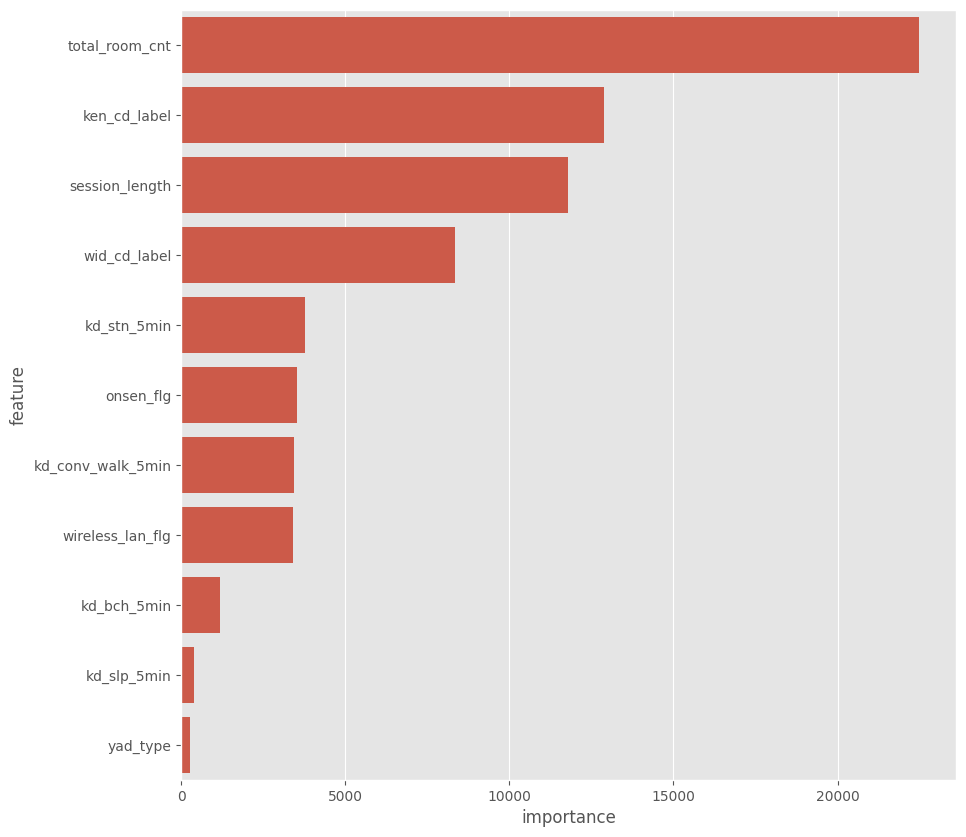

In [40]:
importance_df = pd.DataFrame()
for fold in range(CFG.n_fold):
    model = pickle.load(open(CFG.path_exp / f"lgbm_fold{fold}.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(
    ("importance", "mean"), ascending=False
)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    x="importance",
    y="feature",
    data=importance_df.groupby("feature")
    .agg({"importance": "mean"})
    .reset_index()
    .sort_values("importance", ascending=False),
    ax=ax,
)

In [41]:
pred_prob = np.array([model.predict(test_feat_df.values) for model in models])

In [42]:
pred_prob = np.mean(pred_prob, axis=0)  # axis=0 なので shape の `k` が潰れる

<Axes: ylabel='Count'>

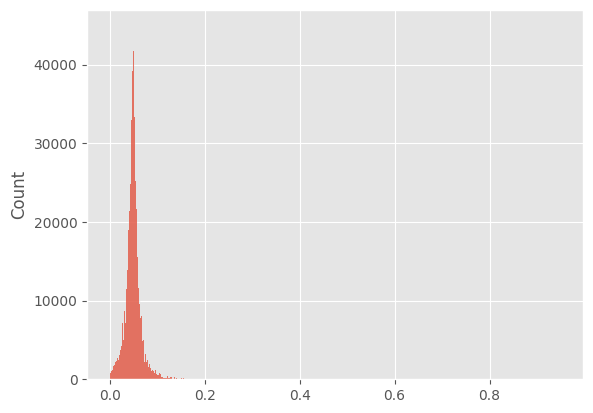

In [44]:
sns.histplot(oof_pred_lgbm)

<Axes: ylabel='Count'>

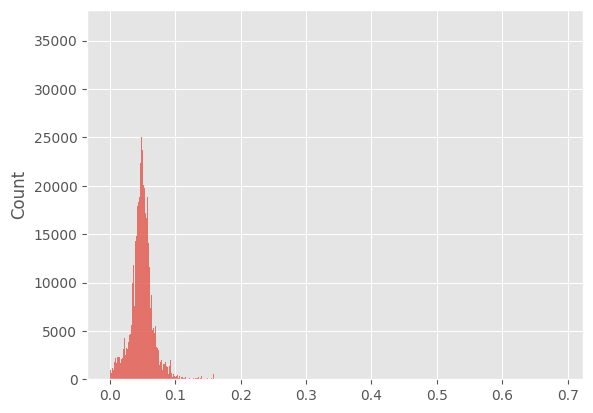

In [45]:
sns.histplot(pred_prob)

In [46]:
test_pred_df = create_top_10_yad_predict(
    predict=pred_prob, session_yad_df=test_candidate_df
)
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_").to_csv(
    CFG.path_exp / "test_pred.csv", index=False
)